<a href="https://colab.research.google.com/github/takumi19910112/google_colab/blob/main/yama_4_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
####################################
# Library
####################################
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import math
import time
import random
import string
import psutil
import pathlib
import datetime
from pathlib import Path
from contextlib import contextmanager
from pprint import pprint
from types import SimpleNamespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")

tokenizers.__version__: 0.21.0
transformers.__version__: 4.48.3


In [ ]:
config = SimpleNamespace()

config.exp_name = '001-exp'
config.exp_comment = 'baseline'
config.seed = 42
config.n_fold = 5
config.wandb = False

# MODEL
config.backbone = 'microsoft/deberta-v3-base'
config.fc_droprate = 0.3
config.max_len = 512
config.num_classes = 3

# TRAIN INFO
config.epochs = 3
config.train_loader = {
    "batch_size": 4,
    "shuffle": True,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": True,
}
config.valid_loader = {
    "batch_size": 4,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": False,
}
config.test_loader = {
    "batch_size": 4,
    "shuffle": False,
    "num_workers": 0,
    "pin_memory": True,
    "drop_last": False,
}
config.optimizer = {
    "name": "torch.optim.AdamW",
    "params": {
        "lr": 2e-5,
        "weight_decay": 0.01,
    },
}
config.scheduler = "cosine"
config.batch_scheduler = True
config.cosine_num_cycles = 0.5
config.pct_wampup_steps = 0.15

config.apex = True
config.gradient_checkpointing = True
config.max_grad = 1000

pprint(config)

namespace(exp_name='001-exp',
          exp_comment='baseline',
          seed=42,
          n_fold=5,
          wandb=False,
          backbone='microsoft/deberta-v3-base',
          fc_droprate=0.3,
          max_len=512,
          num_classes=3,
          epochs=3,
          train_loader={'batch_size': 4,
                        'drop_last': True,
                        'num_workers': 0,
                        'pin_memory': True,
                        'shuffle': True},
          valid_loader={'batch_size': 4,
                        'drop_last': False,
                        'num_workers': 0,
                        'pin_memory': True,
                        'shuffle': False},
          test_loader={'batch_size': 4,
                       'drop_last': False,
                       'num_workers': 0,
                       'pin_memory': True,
                       'shuffle': False},
          optimizer={'name': 'torch.optim.AdamW',
                     'params': {'lr': 2e-05, '

In [ ]:
OUTPUT_DIR = Path(f'./{config.exp_name}')
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f'OUTPUT_DIR: {OUTPUT_DIR}')

OUTPUT_DIR: 001-exp


In [ ]:
## 再現性確保のためのSeed固定
def seed_everything(seed:int==42):

    """pythonとosのseedを固定

    Args:
        seed (int, optional): 固定したいseed値. Defaults to =42.
    """

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

In [ ]:
## 処理にかかった時間と使用したメモリを計測
@contextmanager
def timer(name:str, slack:bool=False):

    """処理にかかった時間と使用したメモリを計測
    """

    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield

    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)

    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec")

In [ ]:
with timer('data load'):

    train_df = pd.read_csv("/content/drive/MyDrive/m_learn/train.csv")
    test_df = pd.read_csv("/content/drive/MyDrive/m_learn/test.csv")
    sub_df = pd.read_csv("/content/drive/MyDrive/m_learn/sample_submission.csv")

    print(f'train: {train_df.shape}')
    print(f'test: {test_df.shape}')
    print(f'sub: {sub_df.shape}')

<< data load >> Start
train: (1233, 3)
test: (828, 3)
sub: (828, 2)
<< data load >> 1.2GB(+0.0GB):1.1sec


In [ ]:
# dataframeの文章の長さなどを取得するために、先にtokenizerを準備
tokenizer = AutoTokenizer.from_pretrained(config.backbone)
config.tokenizer = tokenizer

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [ ]:
class DojoDataset:

    def __init__(self, config, df, train):

        self.config = config
        self.df = df
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):

        inputs = self.config.tokenizer.encode_plus(
            self.df.loc[item, 'text'],
            return_tensors=None,
            add_special_tokens=True,
            max_length=self.config.max_len,
            pad_to_max_length=True,
            truncation=True
        )

        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)

        if self.train:

            labels = self.df.loc[item, 'label']
            labels = torch.tensor(labels, dtype=torch.long)
            return inputs, labels

        else:
            return inputs

In [ ]:
class MeanPooling(torch.nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()

    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings

def gen_attention_mask(batch, seq):
    np.random.seed(42)
    mask = []
    for i in range(batch):
        l = np.random.randint(1, seq, 1)[0]
        mask.append([1.] * l + [0.] * (seq - l))
    return torch.as_tensor(mask)

In [ ]:
class CustomModel(nn.Module):

    def __init__(self, config, config_path, pretrained=False):

        super().__init__()
        self.config = config
        if config_path is None:
            self.model_config = AutoConfig.from_pretrained(self.config.backbone)
            self.model_config.update({"output_hidden_states": True})
            self.model_config.hidden_dropout = 0.
            self.model_config.hidden_dropout_prob = 0.
            self.model_config.attention_dropout = 0.
            self.model_config.attention_probs_dropout_prob = 0.
        else:
            self.model_config = torch.load(config_path)

        if pretrained:
            self.model = AutoModel.from_pretrained(self.config.backbone, config=self.model_config)
        else:
            self.model = AutoModel.from_config(self.model_config)
        # if self.config.gradient_checkpointing:
        #     self.model.gradient_checkpointing_enable()


        self.pool = MeanPooling()
        self.dropouts = nn.ModuleList([nn.Dropout(0.2) for _ in range(5)])
        self.norm = nn.LayerNorm(self.model_config.hidden_size)
        self.fc = nn.Linear(self.model_config.hidden_size, self.config.num_classes)
        self._init_weights(self.fc)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)


    def feature(self, inputs):

        outputs = self.model(
            **inputs
        )
        last_hidden_state = outputs.last_hidden_state
        attention_mask = inputs["attention_mask"]
        feature = self.pool(last_hidden_state, attention_mask)
        # feature = last_hidden_state[:, 0, :]
        return outputs, feature

    def forward(self, inputs):
        _, feature = self.feature(inputs)

        # MultiSampleDropOut
        # outputs = sum([self.fc(dropout(feature)) for dropout in self.dropouts])/5
        outputs = self.fc(feature)

        return outputs

In [ ]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train_func(config, train_loader, model, criterion, optimizer, scheduler, device, epoch):

    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=config.apex)
    losses = AverageMeter()

    tq = tqdm(train_loader, total=len(train_loader))
    for step, (inputs, labels) in enumerate(tq):

        for k, v in inputs.items():
            inputs[k] = v.to(device)

        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=config.apex):
            y_preds = model(inputs)
            # loss = criterion(y_preds.view(-1), labels.view(-1))
            loss = criterion(y_preds.sigmoid(), labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm(model.parameters(), config.max_grad)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()

        end = time.time()
        tq.set_description(f"Train Epoch: {epoch+1:2d} | Loss{losses.avg:.5f}")

    tq.close()
    _ = gc.collect()

    return losses.avg

In [ ]:
def valid_func(valid_loader, model, criterion, device, epoch):

    losses = AverageMeter()
    model.eval()
    tq = tqdm(valid_loader, total=len(valid_loader))
    preds = []

    for step, (inputs, labels) in enumerate(tq):

        for k, v in inputs.items():
            inputs[k] = v.to(device)

        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            out = model(inputs)
            # loss = criterion(out.view(-1), labels.view(-1))
            loss = criterion(out.sigmoid(), labels)

        losses.update(loss.item(), batch_size)
        preds.append(out.sigmoid().detach().cpu().numpy())
        tq.set_description(f"Valid Epoch: {epoch+1:2d} | Loss{losses.avg:.5f}")

    tq.close()
    _ = gc.collect()
    valid_preds = np.concatenate(preds)

    return losses.avg, valid_preds

In [ ]:
def test_func(test_loader, model, device):

    model.eval()
    tq = tqdm(test_loader, total=len(test_loader))
    test_preds = []

    for step, inputs in enumerate(tq):

        for k, v in inputs.items():
            inputs[k] = v.to(device)

        with torch.no_grad():
            out = model(inputs)
            # loss = criterion(out.view(-1), labels.view(-1))

        test_preds.append(out.sigmoid().detach().cpu().numpy())

    tq.close()
    _ = gc.collect()
    test_preds = np.concatenate(test_preds)

    return test_preds

In [ ]:
##############################################
# Optimizer
##############################################

def get_optimizer_params(model, base_lr, weight_decay=0.0):

    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
            'lr': base_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
            'lr': base_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
            'lr': base_lr, 'weight_decay': 0.0}
    ]

    return optimizer_parameters

def get_scheduler(cfg, optimizer, num_train_steps):
    if config.scheduler=='linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=config.pct_wampup_steps,
            num_training_steps=num_train_steps
        )
    elif config.scheduler=='cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=config.pct_wampup_steps,
            num_training_steps=num_train_steps,
            num_cycles=config.cosine_num_cycles
        )
    return scheduler

In [ ]:
train_df['fold'] = -1
skf = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)

for fold, (_, va_idx) in enumerate(skf.split(train_df, train_df['label'])):

    train_df.loc[va_idx, 'fold'] = fold+1

train_df['fold'] = train_df['fold'].astype('int')

pd.pivot_table(train_df, index='fold', columns='label', values='prompt', aggfunc='count')

label,0,1,2
fold,,,
1,83,82,82
2,82,83,82
3,82,82,83
4,82,82,82
5,82,82,82


★★★★★★★★★★★★★★★★ fold1 ★★★★★★★★★★★★★★★★
X_train: 986, X_valid: 247


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  1 | train_loss:0.9109 | valid_loss:0.7808 | valid_score:0.7696 |
Epoch 1 - Saving the best model with score 0.7696


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  2 | train_loss:0.7328 | valid_loss:0.7466 | valid_score:0.7939 |
Epoch 2 - Saving the best model with score 0.7939


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  3 | train_loss:0.6824 | valid_loss:0.7476 | valid_score:0.7853 |


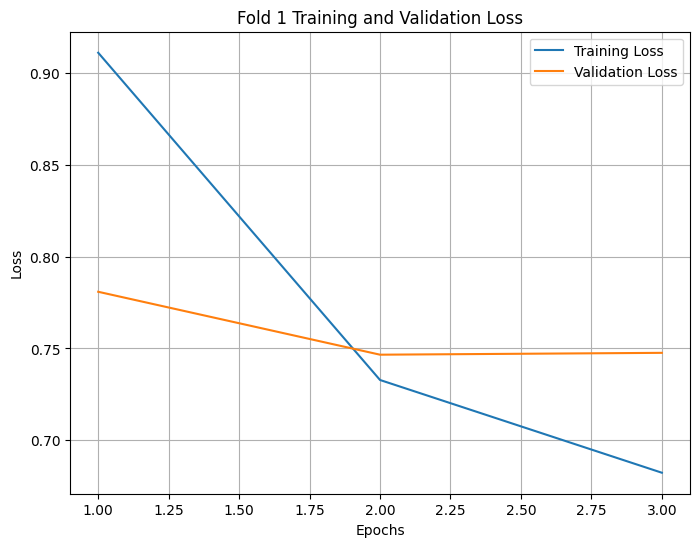

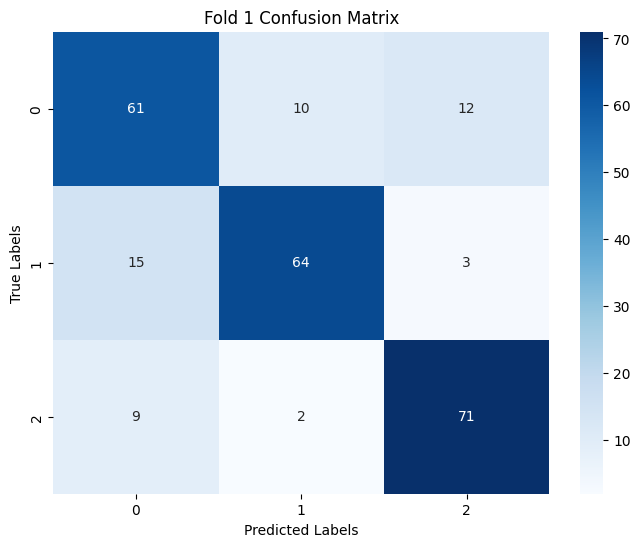

★★★★★★★★★★★★★★★★ fold2 ★★★★★★★★★★★★★★★★
X_train: 986, X_valid: 247


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  1 | train_loss:0.8894 | valid_loss:0.7826 | valid_score:0.7667 |
Epoch 1 - Saving the best model with score 0.7667


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  2 | train_loss:0.7296 | valid_loss:0.7502 | valid_score:0.8005 |
Epoch 2 - Saving the best model with score 0.8005


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  3 | train_loss:0.6925 | valid_loss:0.7523 | valid_score:0.7926 |


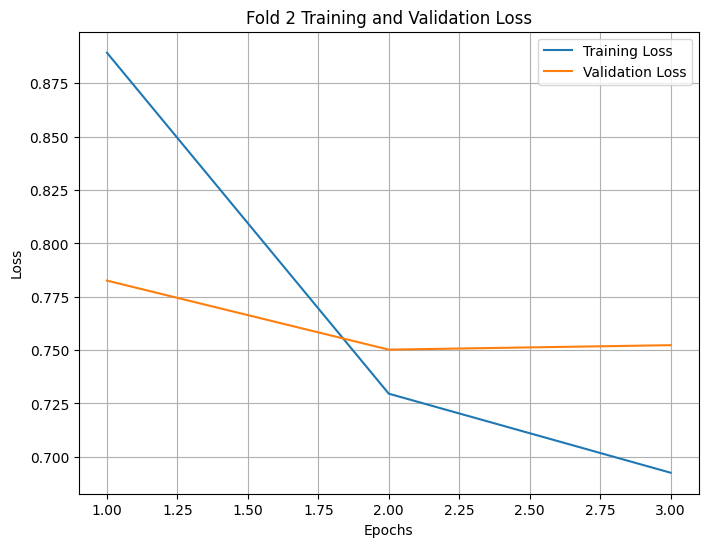

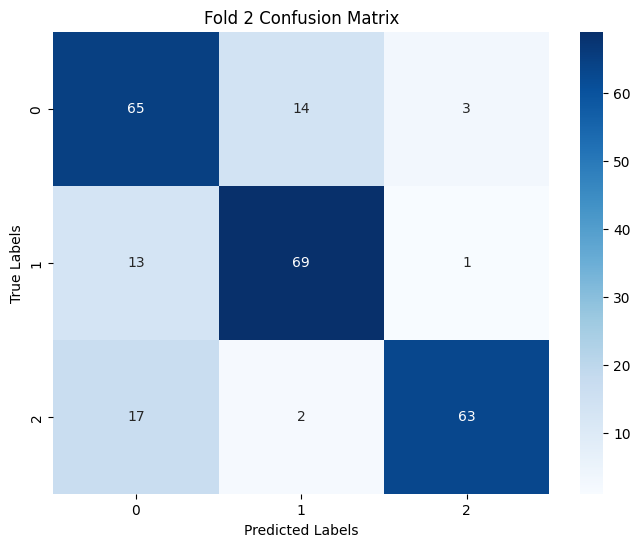

★★★★★★★★★★★★★★★★ fold3 ★★★★★★★★★★★★★★★★
X_train: 986, X_valid: 247


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  1 | train_loss:0.9093 | valid_loss:0.7718 | valid_score:0.7739 |
Epoch 1 - Saving the best model with score 0.7739


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  2 | train_loss:0.7443 | valid_loss:0.7219 | valid_score:0.8225 |
Epoch 2 - Saving the best model with score 0.8225


  0%|          | 0/246 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

Epoch:  3 | train_loss:0.6975 | valid_loss:0.7212 | valid_score:0.8222 |


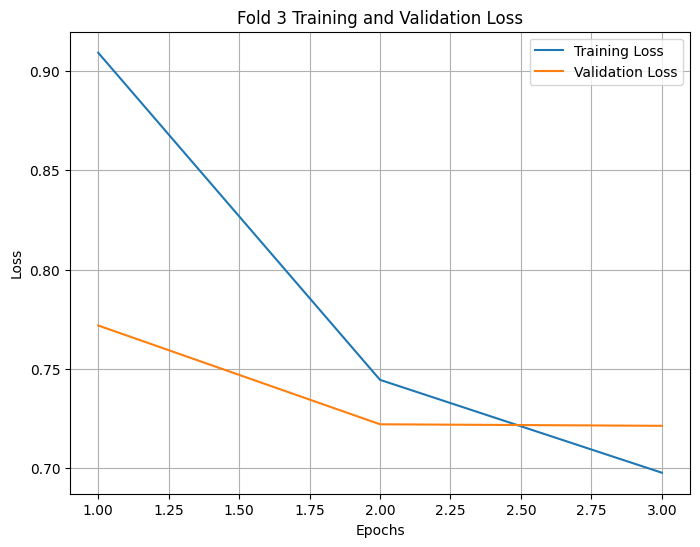

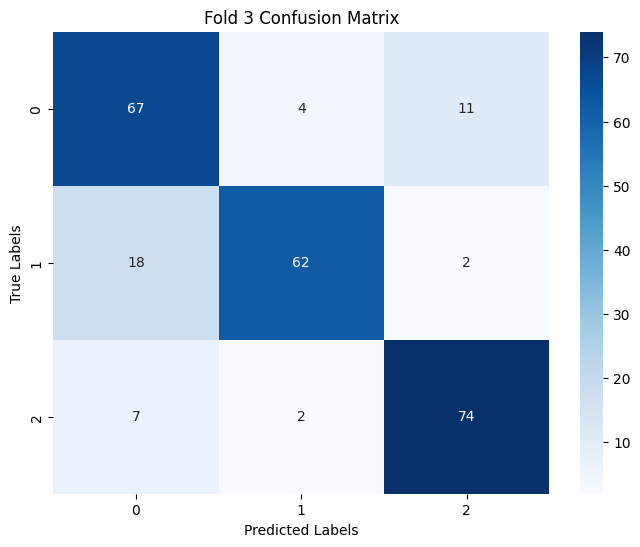

★★★★★★★★★★★★★★★★ fold4 ★★★★★★★★★★★★★★★★
X_train: 987, X_valid: 246


  0%|          | 0/246 [00:00<?, ?it/s]

In [ ]:
oof_prob = np.zeros((len(train_df), config.num_classes))

for fold in range(config.n_fold):

    print(f'★★★★★★★★★★★★★★★★ fold{fold+1} ★★★★★★★★★★★★★★★★')
    seed_everything(config.seed)
    device = 'cuda'

    X_train = train_df.query('fold != @fold + 1').reset_index(drop=True)
    X_valid = train_df.query('fold == @fold + 1').reset_index(drop=True)
    valid_idx = train_df.query('fold == @fold + 1').index.tolist()
    print(f'X_train: {len(X_train):,}, X_valid: {len(X_valid):,}')

    train_dataset = DojoDataset(
        config,
        X_train,
        train=True
    )
    train_loader = DataLoader(
        train_dataset,
        **config.train_loader
    )

    valid_dataset = DojoDataset(
        config,
        X_valid,
        train=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        **config.valid_loader
    )

    ########################## Model #########################
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.model_config, f'{OUTPUT_DIR}/config.pth')
    model.to(device)

    ########################## Optimizer #########################
    optimizer_parameters = get_optimizer_params(
        model,
        base_lr=config.optimizer["params"]["lr"],
        weight_decay=0.01
    )
    optimizer = AdamW(
        optimizer_parameters,
        lr=config.optimizer["params"]["lr"],
        eps=1e-6,
        betas=(0.9, 0.999)
    )

    ########################## Scheduler #########################
    num_train_steps = int(len(X_train) / config.train_loader['batch_size'] * config.epochs)
    scheduler = get_scheduler(config, optimizer, num_train_steps)

    ########################## Loop #########################
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')
    criterion = nn.CrossEntropyLoss(reduction='mean')
    best_score = 0
    best_val_pred = None
    best_model_file_name = f"{OUTPUT_DIR}/{config.exp_name}_fold{fold}.pth"
    train_losses = [] # 学習損失を記録するリスト
    valid_losses = [] # 検証損失を記録するリスト


    for epoch in range(config.epochs):

        train_loss = train_func(
            config,
            train_loader,
            model,
            criterion,
            optimizer,
            scheduler,
            device,
            epoch
        )
        train_losses.append(train_loss) # 学習損失を記録

        valid_loss, valid_pred = valid_func(valid_loader, model, criterion, device, epoch)
        valid_losses.append(valid_loss) # 検証損失を記録

        valid_score = f1_score(
            X_valid['label'],
            np.argmax(valid_pred, axis=1),
            average='macro'
        )

        print(f"Epoch: {epoch+1:2d} | train_loss:{train_loss:.4f} | valid_loss:{valid_loss:.4f} | valid_score:{valid_score:.4f} |")

        if valid_score > best_score:
            best_score = valid_score
            best_val_pred = valid_pred
            print(f"Epoch {epoch+1} - Saving the best model with score {best_score:.4f}")
            torch.save({"model": model.state_dict(), "predictions": valid_pred}, best_model_file_name)
    # 各fold 終了後に損失グラフを可視化する場合 (例: 最終 fold の損失グラフ)
    epochs_range = range(1, config.epochs + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.title(f'Fold {fold+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    # 各fold 終了後に混同行列を可視化する場合 (例: 最終 fold の混同行列)
    valid_labels = X_valid['label'] # 最終 fold の検証データの正解ラベル
    predicted_labels = np.argmax(best_val_pred, axis=1) # 最終 fold の検証データの予測ラベル
    cm = confusion_matrix(valid_labels, predicted_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Fold {fold+1} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    oof_prob[valid_idx] += best_val_pred

In [ ]:
# CV Score
F1Score = f1_score(train_df['label'], np.argmax(oof_prob, axis=1), average='macro')
print(f'CV Score: {F1Score:.5f}')

CV Score: 0.81336


In [ ]:
test_prob = np.zeros((len(test_df), config.num_classes))

for fold in range(config.n_fold):

    print(f'★★★★★★★★★★★★★★★★ fold{fold+1} ★★★★★★★★★★★★★★★★')
    seed_everything(config.seed)
    device = 'cuda'

    test_dataset = DojoDataset(
        config,
        test_df,
        train=False
    )
    test_loader = DataLoader(
        test_dataset,
        **config.test_loader
    )

    ########################## Model #########################
    model = CustomModel(config, config_path=None, pretrained=True)
    state = torch.load(
        f"{OUTPUT_DIR}/{config.exp_name}_fold{fold}.pth",
        map_location=torch.device('cpu')
    )
    model.load_state_dict(state['model'])
    model.to(device)

    test_pred = test_func(test_loader, model, device)
    test_prob += test_pred / config.n_fold

★★★★★★★★★★★★★★★★ fold1 ★★★★★★★★★★★★★★★★


  0%|          | 0/207 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★ fold2 ★★★★★★★★★★★★★★★★


  0%|          | 0/207 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★ fold3 ★★★★★★★★★★★★★★★★


  0%|          | 0/207 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★ fold4 ★★★★★★★★★★★★★★★★


  0%|          | 0/207 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★ fold5 ★★★★★★★★★★★★★★★★


  0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
sub_df['label'] = np.argmax(test_prob, axis=1)
sub_df.to_csv(OUTPUT_DIR / f'{config.exp_name}_{F1Score:.5f}_submission.csv', index=False)

In [ ]:
sub_df

,id,label
0,0,2
1,1,0
2,2,1
3,3,2
4,4,2
...,...,...
823,823,0
824,824,0
825,825,2
826,826,0
